In [1]:
%matplotlib inline

In [2]:
from readS1 import *
import readS1
reload(readS1)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


<module 'readS1' from 'readS1.pyc'>

In [3]:
import gshhs_rasterize
reload(gshhs_rasterize)

<module 'gshhs_rasterize' from '/home/mag/Documents/repos/solab/PySOL/gshhs_rasterize.pyc'>

In [4]:
from numpy import asarray, zeros, reshape, double, arange, \
                  ma, log10, diff, mean, flipud, floor, pi, sqrt, size, fliplr, meshgrid, exp, cos, radians, \
                  empty, NaN, nanmin, nanstd
from scipy.signal import argrelmin, argrelmax

In [5]:
from IPython.html import widgets

In [6]:
import datetime

import matplotlib.pyplot as plt

from matplotlib.mlab import find

from PIL import Image

import pyresample as pr

import os

__author__   = 'Alexander Myasoedov'
__email__    = 'mag@rshu.ru'
__created__  = datetime.datetime(2014, 10, 28)
__modified__ = datetime.datetime(2014, 5, 27)
__version__  = "1.0"
__status__   = "Development"

In [7]:
try:
    import cPickle as pickle
except:
    import pickle

# First we average all the data without masking

## Load saved data

In [8]:
# Uncomment to initiate the dict for further averaged values
if not 'rawCountsAvg' in locals():
    rawCountsAvg = {}
for _dir, sub_dir, fileNameList in os.walk('./dumps'):
    for fn in fileNameList:
        if fn.startswith('rawCountsAvg_bckp') and fn.endswith('.pickle'):
            with open(_dir+'/'+fn, 'rb') as f:
                _rawCountsAvg = pickle.load(f)
                rawCountsAvg.update(_rawCountsAvg)
                f.close()
                del _rawCountsAvg

## Filling the raw_counts array from all of the files

In [9]:
inpath = '/media/SOLabNFS2/store/satellite/sentinel-1/'

for _dir, sub_dir, fileNameList in os.walk(inpath):
    for fn in fileNameList:
        if fn.startswith('S1A_IW_GRD') and fn.endswith('.zip'):
            if fn[-57:-55] == 'DV':
                polarization = ['vv', 'vh']
            elif fn[-57:-55] == 'DH':
                polarization = ['hh', 'hv']
            elif fn[-57:-55] == 'SV':
                polarization = 'vv'
            elif fn[-57:-55] == 'SH':
                polarization = 'hh'
            # Average raw_counts for both polarizations and append to mat file
            # from numpy import empty
            # sz = raw_counts[polarization[0]].shape
            # rawCountsAvg[p] = empty((1, sz[0]), dtype='object')

            # For example, if five students sit a test, and the scores are 24, 85, 89, 91 and 95, the mean score is 60.6.
            # This, however, is untypical — the average has been dragged down by one outlying score of 24,
            # possibly because one student had not been studying.
            # In this case, the median of 89 is much more typical.
            
            # First check if some of the files were not fully processed already
            if len(polarization[0])==1: # if only 1 polarization:
                if ((fn[:-39] not in rawCountsAvg) or \
                ('mean' not in rawCountsAvg[fn[:-39]][polarization]) or \
                ('median' not in rawCountsAvg[fn[:-39]][polarization])):
                    print "Processing %s" % fn
                    try:
                        raw_counts, polarization, _ = readS1.readS1_raw_counts(inpath=inpath, fn=fn)
                    except Exception:
                        print Exception.message
                        continue
                    rawCountsAvg[fn[:-39]] = {}
                    rawCountsAvg[fn[:-39]][polarization] = {}
                    rawCountsAvg[fn[:-39]][polarization]['mean']   = ma.mean  (double(raw_counts[polarization]), axis=0)
                    rawCountsAvg[fn[:-39]][polarization]['median'] = ma.median(double(raw_counts[polarization]), axis=0)
                else:
                    # print "Alredy processed %s" % fn
                    continue
            else:
                if ((fn[:-39] not in rawCountsAvg) or \
                ('mean' not in rawCountsAvg[fn[:-39]][polarization[0]]) or \
                ('median' not in rawCountsAvg[fn[:-39]][polarization[0]]) or \
                ('mean' not in rawCountsAvg[fn[:-39]][polarization[1]]) or \
                ('median' not in rawCountsAvg[fn[:-39]][polarization[1]])):
                    print "Processing %s" % fn
                    try:
                        raw_counts, polarization, _ = readS1.readS1_raw_counts(inpath=inpath, fn=fn)
                    except Exception:
                        print Exception.message
                        continue
                    rawCountsAvg[fn[:-39]] = {}
                    rawCountsAvg[fn[:-39]][polarization[0]] = {}
                    rawCountsAvg[fn[:-39]][polarization[1]] = {}
                    for p in polarization:
                        rawCountsAvg[fn[:-39]][p]['mean']   = ma.mean  (double(raw_counts[p]), axis=0)
                        rawCountsAvg[fn[:-39]][p]['median'] = ma.median(double(raw_counts[p]), axis=0)
                else:
                    # print "Alredy processed %s" % fn
                    continue
            # Get size of a dict
            sizeOfDict = 0
            for v, _ in rawCountsAvg.iteritems():
                for z, _ in rawCountsAvg[v].iteritems():
                    for _, yy in rawCountsAvg[v][z].iteritems():
                        sizeOfDict = sizeOfDict + yy.nbytes
            sizeOfDict = double(sizeOfDict)/1024/1024
            print "rawCountsAvg size, %.2f Mb"  % sizeOfDict
            if sizeOfDict > 1e2:
                print "Size of rawCountsAvg exceeds 100Mb, saving..."
                with open('dumps/rawCountsAvg_bckp' + fn[-54:-41] + '.pickle', 'wb') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump(rawCountsAvg, f, pickle.HIGHEST_PROTOCOL)
                f.close()
                del rawCountsAvg
                rawCountsAvg = {}
# if processing last file
if fn == fileNameList[-1]:
    print "Saving after last file..."
    with open('dumps/rawCountsAvg_bckp' + fn[-54:-41] + '.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(rawCountsAvg, f, pickle.HIGHEST_PROTOCOL)
    f.close()

Processing S1A_IW_GRDH_1SDV_20150326T031855_20150326T031929_005197_0068F2_E50C.zip
<attribute 'message' of 'exceptions.BaseException' objects>
Processing S1A_IW_GRDH_1SDV_20150326T031830_20150326T031855_005197_0068F2_F22F.zip
<attribute 'message' of 'exceptions.BaseException' objects>
Processing S1A_IW_GRDH_1SSV_20150407T124316_20150407T124350_005378_006D47_D64F.zip
<attribute 'message' of 'exceptions.BaseException' objects>
Processing S1A_IW_GRDH_1SSH_20150604T141258_20150604T141321_006224_00820C_A532.zip
<attribute 'message' of 'exceptions.BaseException' objects>
Processing S1A_IW_GRDH_1SSH_20150604T141139_20150604T141208_006224_00820C_9957.zip
<attribute 'message' of 'exceptions.BaseException' objects>
Saving after last file...


In [10]:
def noiseLutAvg(rawCountsAvg, pol='vv', scale=1):
    # http://stackoverflow.com/questions/5083340/find-minimum-element-in-a-dictionary-of-dictionaries
    # http://www.u.arizona.edu/~erdmann/mse350/topics/list_comprehensions.html

    # print ( (rawCountsAvg[k]['vv']['mean']) for k in rawCountsAvg.iterkeys() )
    # min(rawCountsAvg.keys(), key=lambda k:rawCountsAvg[k]['vv']['mean'])

    # get the mean values of VV polarization from the Dictionary
    _vv = map( lambda k: rawCountsAvg[k], rawCountsAvg.iterkeys() )
    __vv = []
    for k in range(len(_vv)):
        if pol in _vv[k]:
            __vv.append(_vv[k][pol]['mean'][::scale])
    # find maximum length of the Data
    _vv_max_len = max(map(len, __vv))
    # create an empty array for further values filling
    vv = empty((_vv_max_len, len(__vv)))
    vv.fill(NaN)
    for j in arange(len(__vv)):
        vv[0:len(__vv[j]),j] = __vv[j]
#     del _vv, __vv, _vv_max_len
    print "Number of %s images = %i" % (pol, len(vv[0,:]))
    return vv

In [11]:
def noiseLutMskEdgs(nLt):
    nLtMasked = ma.array(nLt, fill_value=NaN)
    # Mask drops of values on the edges before averaging
    for j in arange(nLt.shape[1]):
        # find peak values
        minpeak = argrelmin(nLt[:,j], order=int(round(nanstd(nLt[:,j])))*1, mode='wrap')[0]
        maxpeak = argrelmax(nLt[:,j], order=2, mode='wrap')[0]
        # take minimum of the max peak
        # take maximum of the min peak
        # to crop as much as possible, avoiding fake dropping values
        peakInd = [
                    max(minpeak[0],maxpeak[0]),
                    min(minpeak[-1],maxpeak[-1])
                  ]
        nLtMasked[0:peakInd[0],j] = ma.masked
        nLtMasked[peakInd[1]:-1,j] = ma.masked
    return nLtMasked

In [12]:
nLt = noiseLutAvg(rawCountsAvg, pol='vh', scale=10)
nLtMasked = noiseLutMskEdgs(nLt)

Number of vh images = 991


/usr/local/lib/python2.7/dist-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/usr/local/lib/python2.7/dist-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)
/usr/local/lib/python2.7/dist-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/usr/local/lib/python2.7/dist-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


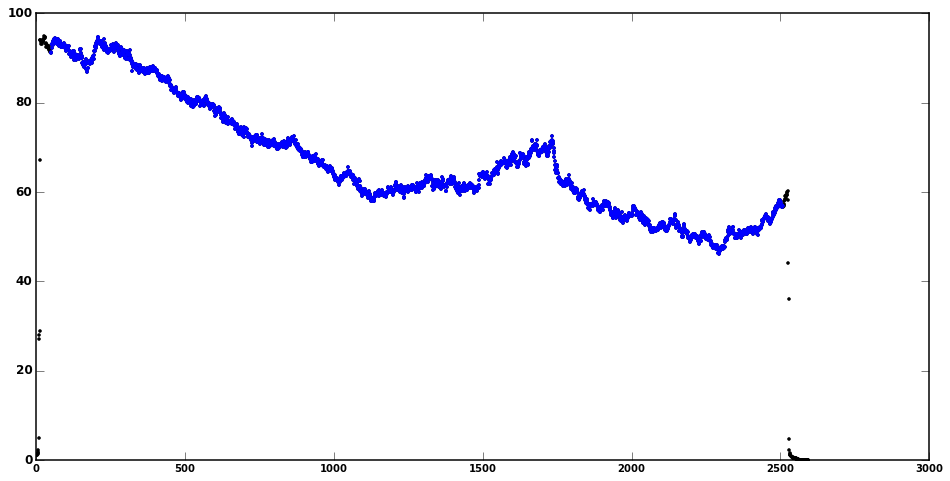

In [13]:
plt.close('all')
plt.figure(figsize=(16,8))
plt.plot(nLt[:,33], 'k.')
plt.plot(nLtMasked[:,33], 'b.')
# plt.plot(nLtMasked[:,3][~nLtMasked[:,3].mask], 'b.')

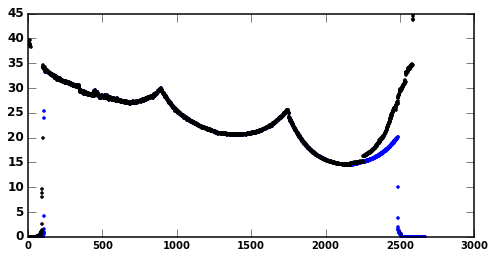

In [14]:
plt.close('all')
plt.figure(figsize=(8,4))
plt.plot(nanmin(nLt, axis=1), 'b.')
plt.plot(nLtMasked.min(axis=1), 'k.')

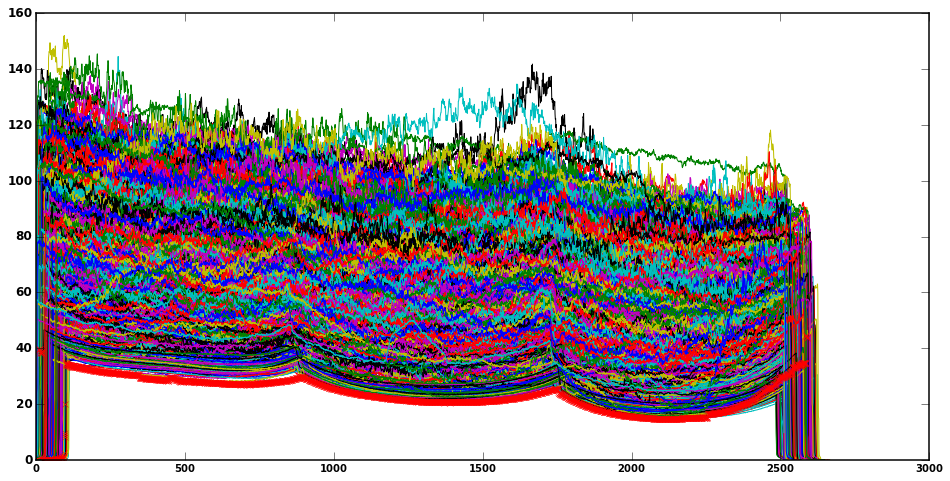

In [15]:
plt.close('all')
plt.figure(figsize=(16,8))
plt.plot(nLt)
# plt.plot(nanmin(nLt, axis=1), 'yo')
plt.plot(nLtMasked.min(axis=1), 'rx')


# Open test file to compare noise

In [16]:
# Ania_Ladoga_29_May_2015/
inpath = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Ania_Ladoga_29_May_2015/'
fn = 'S1A_IW_GRDH_1SDV_20150603T154002_20150603T154027_006211_0081A9_5F10.zip'

s1 = readS1.readS1(inpath=inpath, fn=fn)

Available polarizations: '[u'vv', u'vh']'
Reading raw_counts: 'vv' polarization
Interpolating LUTs: 'vv' polarization
Reading raw_counts: 'vh' polarization
Interpolating LUTs: 'vh' polarization


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2221: DecompressionBombWarning: Image size (426079965 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [17]:
# get vars from s1 class
for k, v in s1.__dict__.iteritems():
    locals()[k]=v

In [18]:
scale = 10
p='vh'
nLt = noiseLutAvg(rawCountsAvg, p, scale=10)
nLtMasked = noiseLutMskEdgs(nLt)
nLtMin = nLtMasked.min(axis=1)

Number of vh images = 991


In [19]:
# Preserving shapes of noiseLUTs and raw_counts
print nLtMin.shape
print raw_counts[p][::scale,::scale].shape
print (nLtMin)[0:raw_counts[p][::scale,::scale].shape[1]].shape
# I have to take into account difference in incident angles for different images
# what makes the averaged NoiseLUT shift from its true values
# You can see that in the plot
print (nLtMin)[\
                nLtMin.shape[0]-raw_counts[p][::scale,::scale].shape[1]::].shape

(2667,)
(1665, 2560)
(2560,)
(2560,)


/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.dev1-py2.7-linux-x86_64.egg/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


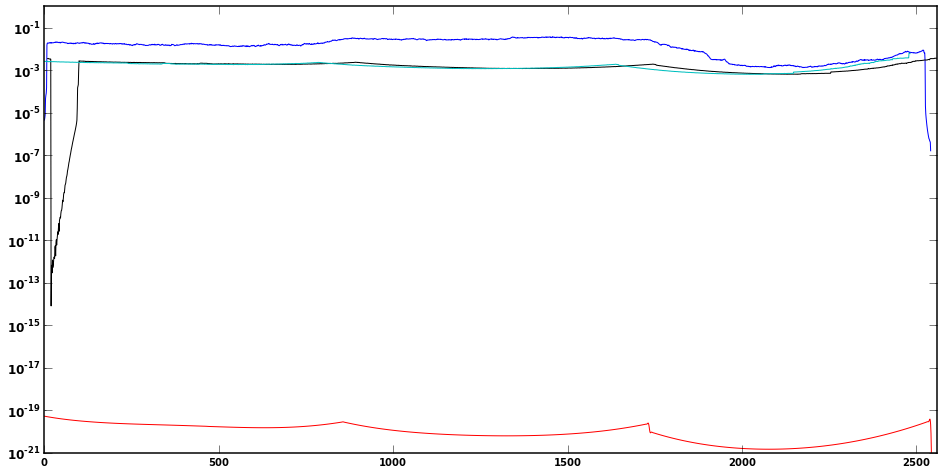

In [20]:
plt.close('all')
plt.figure(figsize=(16,8))
plt.semilogy( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2)/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.hold(True)
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)**2/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2 , 'r')
plt.semilogy( (nLtMin)[0:raw_counts[p][::scale,::scale].shape[1]]**2/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2, 'k')
plt.semilogy( (nLtMin)[\
                        nLtMin.shape[0]-raw_counts[p][::scale,::scale].shape[1]::]**2/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2, 'c')
plt.ylim(1e-21,1)
plt.xlim(0,raw_counts[p][::scale,::scale].shape[1])
plt.axes()
plt.show()

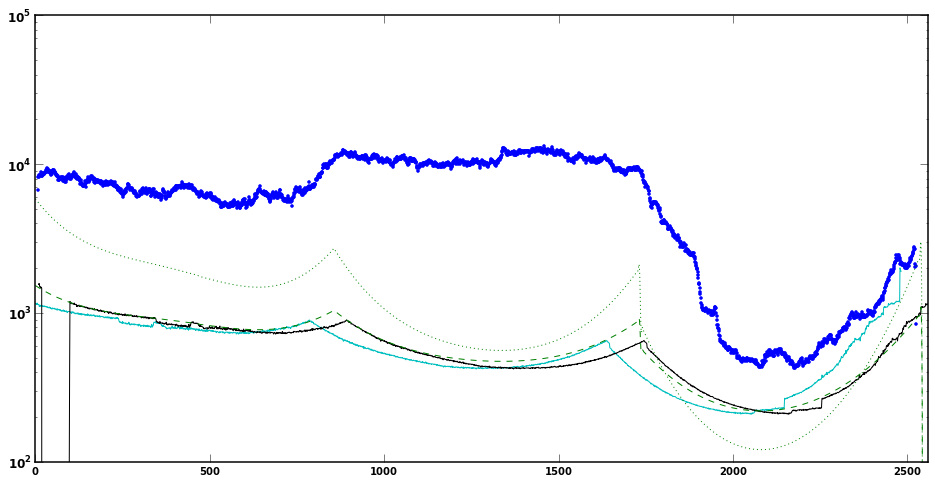

In [21]:
# for VH - multiply S1 noiseLUTs by nLtCoeff=1e10
# for VV - multiply S1 noiseLUTs by nLtCoeff=sqrt(2)*1e10
nLtCoeff = sqrt(1)*1e10

plt.close('all')
plt.figure(figsize=(16,8))
plt.hold(True)
plt.semilogy( double(raw_counts[p][::scale,::scale].mean(axis=0))**2, 'b.' )
# I have to take into account difference in incident angles for different images
# what makes the averaged NoiseLUT shift from its true values
# You can see that in the plot
plt.semilogy( (nLtMin)[\
                        nLtMin.shape[0]-raw_counts[p][::scale,::scale].shape[1]::]**2, 'c')
plt.semilogy( (nLtMin)[0:raw_counts[p][::scale,::scale].shape[1]]**2, 'k' )
plt.semilogy( (noiseLut_2[p][::scale,::scale].mean(axis=0)*5e8)**2, 'g:' )
plt.semilogy( (noiseLut_2[p][::scale,::scale].mean(axis=0)*nLtCoeff), 'g--' )
plt.ylim(1e2,1e5)
plt.xlim(0,raw_counts[p][::scale,::scale].shape[1])
plt.show()

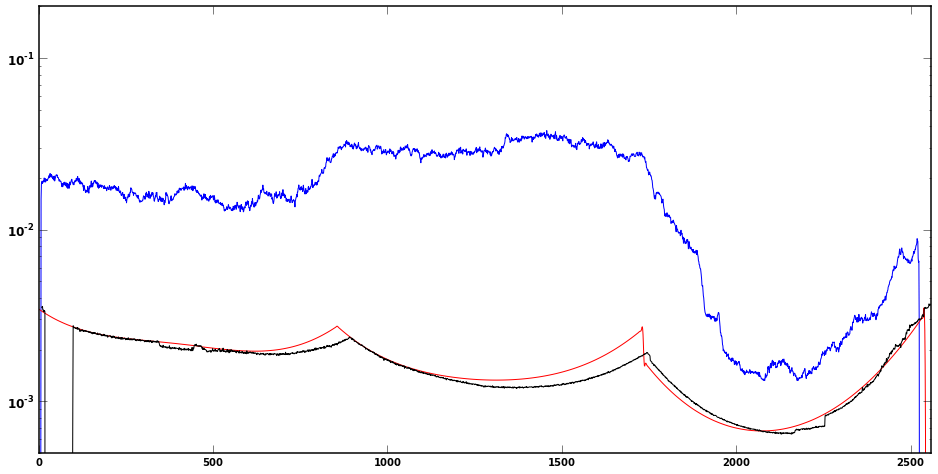

In [22]:
plt.close('all')
plt.figure(figsize=(16,8))
plt.hold(True)
plt.semilogy( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2)/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)*nLtCoeff/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2 , 'r')
plt.semilogy( (nLtMin)[0:raw_counts[p][::scale,::scale].shape[1]]**2/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2, 'k')
plt.ylim(5e-4,.2)
plt.xlim(0,raw_counts[p][::scale,::scale].shape[1])
plt.axes()
plt.show()

## Corrected raw_counts

### For VV

Number of vv images = 2106


(200.0, 10000.0)

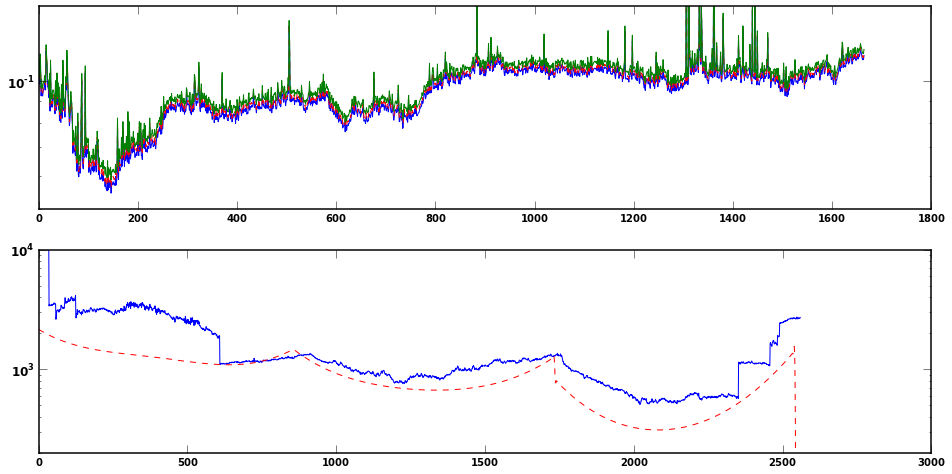

In [59]:
scale = 10
p='vv'
nLt = noiseLutAvg(rawCountsAvg, p, scale)
nLtMasked = noiseLutMskEdgs(nLt)
nLtMin = nLtMasked.min(axis=1)
nLtCoeff=sqrt(2)*1e10

rc = double(raw_counts[p][::scale,::scale])**2
nl_s1 = (noiseLut_2[p][::scale,::scale].mean(axis=0))*nLtCoeff
nl = (nLtMin)[0:raw_counts[p][::scale,::scale].shape[1]]**2
# Apply Calibration, remove the thermal noise estimation and Convert to Intensity
s0_s1 = (rc - nl_s1 )/sigmaNought_2[p][::scale,::scale]**2
s0    = (rc - nl )/sigmaNought_2[p][::scale,::scale]**2

s0crrctd = {}
s0crrctd[p] = s0_s1

plt.close('all')
plt.figure(figsize=(16,8))
plt.hold(True)
plt.subplot(211)
plt.semilogy( s0.mean(axis=1) )
plt.semilogy( s0_s1.mean(axis=1), 'r--' )
plt.semilogy( (rc/sigmaNought_2[p][::scale,::scale]**2).mean(axis=1), 'g' )
plt.ylim(5e-2,1.5e-1)
plt.subplot(212)
plt.semilogy( nl )
plt.semilogy( nl_s1, 'r--' )
plt.ylim(2e2,1e4)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


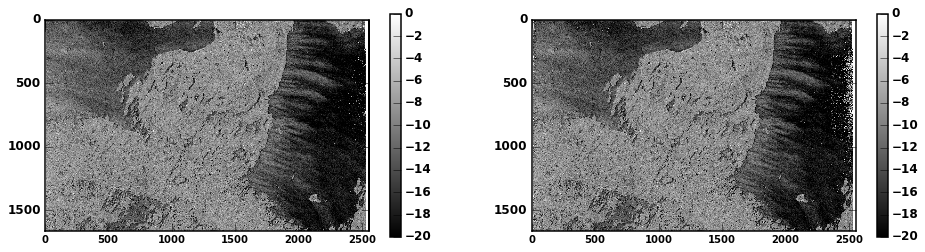

In [24]:
plt.figure(figsize=(16,4))
plt.hold(True)
plt.subplot(121)
plt.imshow( 10*log10(s0_s1), vmin=-20, vmax=0 )
plt.colorbar()
plt.gray()
plt.subplot(122)
plt.imshow( 10*log10(s0), vmin=-20, vmax=0 )
plt.colorbar()
plt.gray()


### For VH

Number of vh images = 991


(200.0, 2000.0)

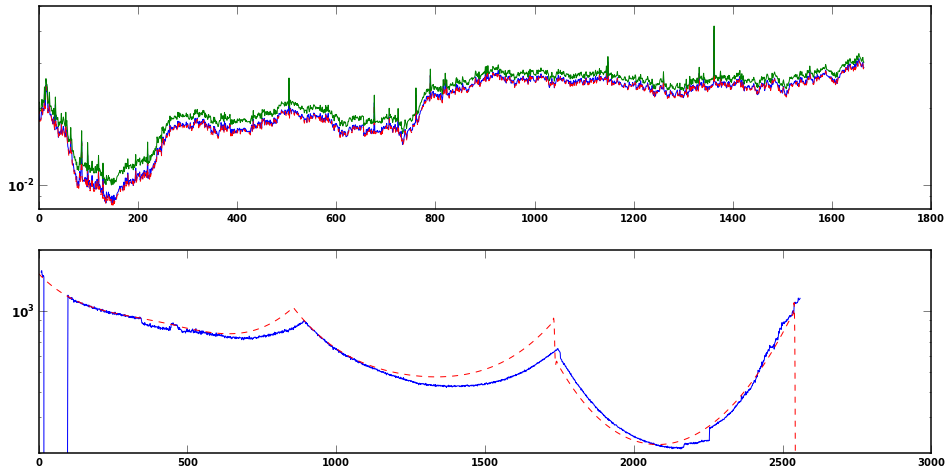

In [60]:
scale = 10
p='vh'
nLt = noiseLutAvg(rawCountsAvg, p, scale)
nLtMasked = noiseLutMskEdgs(nLt)
nLtMin = nLtMasked.min(axis=1)
nLtCoeff=1e10

rc = double(raw_counts[p][::scale,::scale])**2
nl_s1 = (noiseLut_2[p][::scale,::scale].mean(axis=0))*nLtCoeff
nl = (nLtMin)[0:raw_counts[p][::scale,::scale].shape[1]]**2
# Apply Calibration, remove the thermal noise estimation and Convert to Intensity
s0_s1 = (rc - nl_s1 )/sigmaNought_2[p][::scale,::scale]**2
s0    = (rc - nl )/sigmaNought_2[p][::scale,::scale]**2

# s0crrctd = {}
s0crrctd[p] = s0_s1

plt.close('all')
plt.figure(figsize=(16,8))
plt.hold(True)
plt.subplot(211)
plt.semilogy( s0.mean(axis=1) )
plt.semilogy( s0_s1.mean(axis=1), 'r--' )
plt.semilogy( (rc/sigmaNought_2[p][::scale,::scale]**2).mean(axis=1), 'g' )
plt.ylim(8e-3,5e-2)
plt.subplot(212)
plt.semilogy( nl )
plt.semilogy( nl_s1, 'r--' )
plt.ylim(2e2,2e3)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


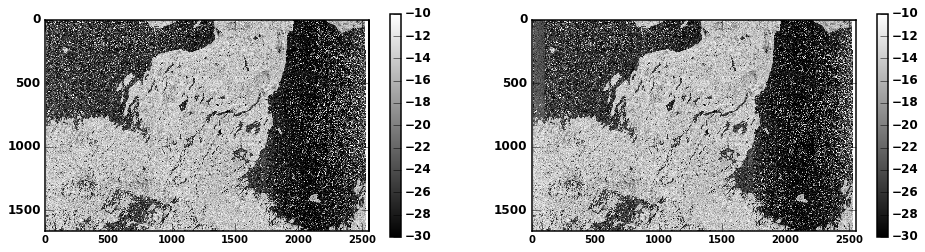

In [61]:
plt.figure(figsize=(16,4))
plt.hold(True)
plt.subplot(121)
plt.imshow( 10*log10(s0_s1), vmin=-30, vmax=-10 )
plt.colorbar()
plt.gray()
plt.subplot(122)
plt.imshow( 10*log10(s0), vmin=-30, vmax=-10 )
plt.colorbar()
plt.gray()


### Smooth the data

In [62]:
for p in polarization:
    s0crrctd[p] = wiener(s0crrctd[p], mysize=(7,7), noise=None)

In [63]:
# S1 Pixel resolution
# we use pxlResSAR for further GSHHS rasterizing and reprojecting data with pyresample

lonlim = (lons_2[::scale,::scale].min(),lons_2[::scale,::scale].max())
latlim = (lats_2[::scale,::scale].min(),lats_2[::scale,::scale].max())

# enlarge lonlims for cropping a bit larger area for masking
lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)


# Get first guess pixel resolution
import distancelib
pxlResSARm  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                     lons_2[::scale,::scale], \
                                                     lons_2[::scale,::scale].shape, 'km'))*1e3
pxlResSARdeg  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                       lons_2[::scale,::scale], \
                                                       lons_2[::scale,::scale].shape, 'deg'))

print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)

S1 cell resolution, [ 0.00091175  0.00089496] deg
S1 cell resolution, [ 101.31403896   99.44836973] m


In [64]:
import pyresample as pr
from pyproj import Proj

# Define areas with pyresample
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])

area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=pxlResSARm)

In [65]:
# Get the SAR pixel resolution from the area_def for further identical shapes
up    = min(latlimGSHHS)
down  = max(latlimGSHHS)
left  = min(lonlimGSHHS)
right = max(lonlimGSHHS)
area_extent_deg = (left, down, right, up)

area_extent_deg_shape = area_def_4326.shape

pxlResSARdeg = asarray( (abs(area_extent_deg[2] - area_extent_deg[0]) / float(area_extent_deg_shape[1]), \
                abs(area_extent_deg[3] - area_extent_deg[1]) / float(area_extent_deg_shape[0])) )

pxlResSARm = asarray( (area_def_4326.pixel_size_x, area_def_4326.pixel_size_y) )
print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)


S1 cell resolution, [ 0.00091012  0.00089342] deg
S1 cell resolution, [ 101.31421131   99.45559361] m


In [66]:
# Apply Mask from GSHHS

import gshhs_rasterize
reload(gshhs_rasterize)

# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

# reproject GSHHS onto S1 grid before calculations
print "Rasterizing Land Mask"
mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(lonlimGSHHS, latlimGSHHS, \
                                     pxlResSARdeg, area_def_4326.shape, True, \
                                     shapefile)
mask_arr_swath = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, swath_def, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

Rasterizing Land Mask


### NB! Don't forget to flipud when bearing.mean() >200
### NB! Don't forget to fliplr when bearing.mean() < 200

In [69]:
roughness = {}
sigma0wAvg = {}
roughnessNrmlzd = {}
for p in polarization:
        roughness[p] = ma.masked_where(mask_arr_swath, s0crrctd[p])
        sigma0wAvg[p] = ma.median(roughness[p], axis=0)
        roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]
del roughness, sigma0wAvg

In [67]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
# bearing_2 = imresize(bearing, ncepGFSmodelWindSwath['wind_dir'].shape)

In [68]:
print 'bearing = %.2f' % bearing.mean()

if bearing.mean() < 200:
#     mask_arr_swath = fliplr(mask_arr_swath)
#     wind_speed_asar = fliplr(wind_speed_asar)
    lats_2 = fliplr(lats_2)
    lons_2 = fliplr(lons_2)
#     for k, v in ncepGFSmodelWindSwath.iteritems():
#         ncepGFSmodelWindSwath[k] = fliplr(v)
    for k, v in roughnessNrmlzd.iteritems():
        roughnessNrmlzd[k] = fliplr(v)
#     for k, v in sigma0w.iteritems():
#         sigma0w[k] = fliplr(v)
#     for k, v in s0crrctd.iteritems():
#         s0crrctd[k] = fliplr(v)

elif bearing.mean() > 200:
#     mask_arr_swath = flipud(mask_arr_swath)
#     wind_speed_asar = flipud(wind_speed_asar)
    lats_2 = flipud(lats_2)
    lons_2 = flipud(lons_2)
#     for k, v in ncepGFSmodelWindSwath.iteritems():
#         ncepGFSmodelWindSwath[k] = flipud(v)
    for k, v in roughnessNrmlzd.iteritems():
        roughnessNrmlzd[k] = flipud(v)
#     for k, v in sigma0w.iteritems():
#         sigma0w[k] = flipud(v)
#     for k, v in s0crrctd.iteritems():
#         s0crrctd[k] = flipud(v)

del k,v

bearing = 349.23


In [70]:
def ntrctv_imshow(p = 'hh', vmi=-1., vma=1., cmap='RdBu_r'):
    plt.figure(figsize=(16,16*double(data[p].shape[0])/double(data[p].shape[1])))
    plt.imshow((data[p]), vmin=vmi, vmax=vma)
    plt.colorbar()
    plt.set_cmap(cmap)

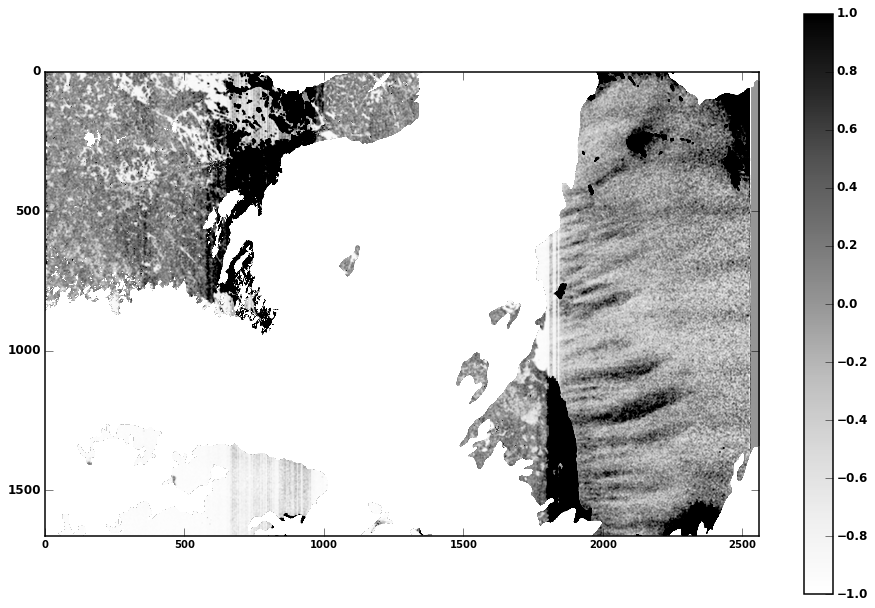

In [71]:
data=roughnessNrmlzd.copy()
# data[p] = np.where(data[p]<-1,-1,data[p])
# data[p] = np.where(data[p]>1,1,data[p])

ntrctv = widgets.interact(ntrctv_imshow, p = widgets.RadioButtons(description='polarization', options=data.keys()), \
                 vmi=widgets.FloatSliderWidget(min=-2, max=2, value=-1, step=0.1), \
                 vma=widgets.FloatSliderWidget(min=-2, max=2, value=1., step=0.1), \
                cmap = ['RdBu_r', 'Greys', 'bone']);

In [ ]:
p = 'hv'

In [ ]:
plt.close('all')
plt.imshow(noiseLut_2[p][::scale,::scale])

In [ ]:
plt.close('all')
plt.figure()
plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0), 'b')
# plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0)*1e6, 'r')
plt.show()

In [ ]:
plt.close('all')
plt.semilogy( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2)/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.hold(True)
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)**2/sigmaNought_2[p][::scale,::scale].mean(axis=0) , 'r')
plt.axes()
plt.show()

In [ ]:
plt.close('all')
plt.semilogy( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 )
plt.semilogy( noiseLut_2['hh'][::scale,::scale].mean(axis=0)*1e13, '--' )
plt.semilogy( noiseLut_2['hv'][::scale,::scale].mean(axis=0)*1e13, ':k')
# plt.ylim(1e3,2e4)
plt.show()

In [ ]:
plt.close('all')
plt.imshow( 10*log10( (double(raw_counts[p][::scale,::scale])**2 - noiseLut_2[p][::scale,::scale]*1e13 )/sigmaNought_2[p][::scale,::scale]**2),
           vmin=-20, vmax=0)
plt.gray()
plt.colorbar()
plt.show()

In [ ]:
# sigma0[p] = ( double(raw_counts[p])**2 - noiseLut_2[p] )/sigmaNought_2[p]**2

plt.close('all')
plt.plot( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 - noiseLut_2[p][::scale,::scale].mean(axis=0)     )/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.plot( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 - noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13 )/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2, 'k:')
# plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13, 'r')
plt.show()

In [ ]:
# Try to split the image into several parts and normalize each part to remove the scalloping effect
# which is still visible even after ESA applies the TOPSAR technique
# https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes/interferometric-wide-swath

In [ ]:
# From https://gist.github.com/endolith/250860

from numpy import NaN, Inf, arange, isscalar, asarray, array
 
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
 
    return array(maxtab), array(mintab)

In [ ]:
# Find the peaks value index to split the image in several parts
# NB! We use sigma0 data for peaks not the LUTs, as the peaks in data and LUTs are a bit different, We believe the data itself, not the LUTs
# First guess number of peaks calculated from LUTs
from scipy.signal import argrelmax
nsLutIndLen = len(argrelmax(noiseLut_2[p][::scale,::scale].mean(axis=0), order=10, mode='wrap')[0])
#  Loop is done comparing vector to some threshold value until peaks are found
for ii in xrange(1,500,2):
    maxtab = peakdet(sigma0wAvg[p], 1e-6*ii)[0]
#     print len(maxtab[:,0])
    if len(maxtab[:,0]) == nsLutIndLen:
        break
sgmPeakInd = maxtab[:,0]

In [ ]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.hold(True)
plt.plot(arange(sgmPeakInd[1],sgmPeakInd[2]),sigma0wAvg[p][sgmPeakInd[1]:sgmPeakInd[2]], 'r')
plt.plot(maxtab[:,0], maxtab[:,1], 'go')
plt.show()

In [ ]:
rghns1 = roughness[p][0:900,sgmPeakInd[1]:sgmPeakInd[2]]
sgmAvg1 = rghns1.mean(axis=1)
rghnsNrmlzd = (rghns1.T-sgmAvg1)/sgmAvg1
rghnsNrmlzd = rghnsNrmlzd.T

In [ ]:
print argrelmax(sgmAvg1, order=30, mode='wrap')
print diff(argrelmax(sgmAvg1, order=30, mode='wrap'))
print '\n'

from scipy.signal import argrelmin
print argrelmin(sgmAvg1, order=30, mode='wrap')
print diff(argrelmin(sgmAvg1, order=30, mode='wrap'))

print mean(diff(argrelmax(sgmAvg1, order=30, mode='wrap')))
print mean(diff(argrelmin(sgmAvg1, order=30, mode='wrap'))[0,1:-1])


In [ ]:
print peakdet(sgmAvg1, 2e-4)[0][:,0]
print diff(peakdet(sgmAvg1, 2e-4)[0][:,0])
mean(diff(peakdet(sgmAvg1, 2e-4)[0][:,0]))

In [ ]:
plt.close('all')
# plt.plot(3*log10(noiseLut_2[p][::scale,::scale][600,:]))
plt.plot(10*log10(noiseLut_2[p][::scale,::scale][600,:]*1e6), 'k')
# plt.plot(10*log10(noiseLut_2[p][::scale,::scale][600,:]))
plt.hold(True)
plt.plot(10*log10(sigma0w[p][600,:]), 'r')
plt.plot(10*log10(sigma0w[p][600,:]-noiseLut_2[p][::scale,::scale][600,:]*1e6), 'g')
# plt.ylim((-110,-23))
plt.ylim((-37,-23))
plt.show()

In [ ]:
plt.close('all')
plt.plot(sgmAvg1)
# plt.hold(True)
# plt.plot(maxtab[:,0], maxtab[:,1], 'go')
plt.show()

In [ ]:
from scipy import fftpack

# Take the fourier transform of the image.
f1 = fftpack.fft(sgmAvg1)

# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 1D fourier transformed image.
fshift = fftpack.fftshift( f1 )

# Calculate a 1D power spectrum
psd1D = abs( fshift )**2

In [ ]:
plt.close('all')
plt.plot(log10( psd1D ))
plt.show()

In [ ]:
fftShiftInd = peakdet(psd1D, 2e-4)[0][:,0]
print fftShiftInd

In [ ]:
# remove the low frequencies by masking with a rectangular window
# High Pass Filter (HPF)
# rows, cols = noiseLut_2[p][::scale,::scale].shape
# crow,ccol = rows/2 , cols/2
# fshift[crow-10:crow-9, ccol-10:ccol+10] = 0

fshiftFiltered = fshift

fftShiftInd = peakdet(psd1D, 2e-4)[0][:,0]
for i in range(0,len(fftShiftInd)/2):
    fshiftFiltered[fftShiftInd[i]]=0
for i in range(len(fftShiftInd)/2+1,len(fftShiftInd)):
    fshiftFiltered[fftShiftInd[i]]=0
    
# fshiftFiltered[fftShiftInd[0]]=0
# fshiftFiltered[fftShiftInd[1]]=0
# fshiftFiltered[fftShiftInd[3]]=0
# fshiftFiltered[fftShiftInd[4]]=0

# Calculate a 1D power spectrum
psd1DFiltered = abs( fshiftFiltered )**2

# shift back (we shifted the center before)
f_ishift = fftpack.ifftshift(fshiftFiltered)

# inverse fft to get the image back
img_back = fftpack.ifft(f_ishift)
img_back = abs(img_back)

In [ ]:
plt.close('all')
plt.plot(log10( psd1D ))
plt.hold(True)
plt.plot(log10( psd1DFiltered ))
plt.show()

In [ ]:
plt.close('all')
plt.plot(sgmAvg1)
plt.hold(True)
plt.plot(img_back, 'g--')
plt.show()

In [ ]:
plt.close('all')
plt.figure(figsize=(8,32/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(rghns1, vmin=0, vmax=0.01)
plt.gray()
plt.subplot(122)
plt.imshow(rghnsNrmlzd, vmin=-1, vmax=1)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

plt.set_cmap('bone_r')
plt.show()

In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('magican', '5di4fue0lf')

noiseLutInd = Scatter(
        y=sigma0wAvg[p],
        mode='markers',
        marker=Marker(
            color='red',
            symbol='square'
        )
    )
data = Data([noiseLutInd])

# (3) Make Figure object
fig = Figure(data=data)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='noiseLutInd')
# plot_url = py.plot(fig, filename='noiseLutInd')

In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('magican', '5di4fue0lf')

data = Data([
    Heatmap(
        z=flipud(roughnessNrmlzd['hh'][::10,::10]),
        colorscale='Greys',
        zauto=False,
        zmin=-1,
        zmax=1
    )
])

layout = Layout(
    autosize=True,
#     autosize=False,
#     width=roughnessNrmlzd['hh'].shape[1]/3,
#     height=roughnessNrmlzd['hh'].shape[0]/3,
)

# (3) Make Figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='roughnessNrmlzd')
# plot_url = py.plot(fig, filename='noiseLutInd')

In [ ]:
# %matplotlib inline

def ntrctv_imshow(p = 'hh', vmi=-1., vma=1., cmap='Greys'):
    plt.figure(figsize=(8,8*double(data[p].shape[0])/double(data[p].shape[1])))
    plt.imshow(data[p], vmin=vmi, vmax=vma)
    plt.colorbar()
    plt.set_cmap(cmap)

In [ ]:
data=roughnessNrmlzd.copy()

ntrctv = widgets.interact(ntrctv_imshow, p = widgets.RadioButtons(description='polarization', options=data.keys()), \
                 vmi=widgets.FloatSliderWidget(min=-2, max=2, value=-1, step=0.1), \
                 vma=widgets.FloatSliderWidget(min=-2, max=2, value=1., step=0.1), \
                cmap = ['binary', 'Blues', 'BuGn', 'BuPu', 'gist_yarg',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']);

In [ ]:
import sys
sys.getsizeof(sigma0[p])

In [ ]:
s1 = sigma0[p]

In [ ]:
import numpy as np
s1

In [ ]:
np.int8(s1).nbytes

In [ ]:
plt.close('all')
plt.imshow(incidenceAngle_2[p][::scale,::scale])

In [ ]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.plot(sigma0w[p].mean(axis=0), 'g')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.imshow(roughness[p], vmin=0, vmax=0.01)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
# plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()
plt.colorbar()
plt.title(p)
plt.subplot(122)
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.gray()
plt.colorbar()
plt.title(p + ' Nrmlzd')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
# plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(131)
plt.imshow(10*log10(sigma0w[polarization[0]]), vmin=-20, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[0])
plt.subplot(132)
plt.imshow(10*log10(sigma0w[polarization[1]]), vmin=-30, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[1])
# plt.subplot(133)
# plt.imshow(roughness[polarization[0]][::scale,::scale], vmin=0, vmax=roughness[polarization[0]].mean())
# plt.gray()
# plt.colorbar()
# plt.title(polarization[0])

In [ ]:
# Adding Model wind

startTime = datetime.datetime.strptime(\
                              manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]\
                              ['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],\
                              "%Y-%m-%dT%H:%M:%S.%f")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(ncepGFSmodelWind['wind_speed'])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(ncepGFSmodelWind['wind_dir'])
plt.jet()
plt.colorbar()


In [ ]:
# plt.close('all')
# plt.figure(figsize=(16,4))
# plt.subplot(121)
# plt.imshow(ncepGFSmodelWind['lats_wind'])
# plt.jet()
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(ncepGFSmodelWind['lons_wind'])
# plt.jet()
# plt.colorbar()

In [ ]:
# plt.close('all')
# plt.plot(ncepGFSmodelWind['lons_wind'][0,:])
# plt.plot(ncepGFSmodelWind['lats_wind'][:,0])

In [ ]:
# Reprojecting data

import distancelib

# Pixel resolution
# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lons_wind'].shape, 'km'))
# pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "S1 cell resolution, %s m"  % pxlResSARm
print "Wind cell resolution, %s km" % pxlResWind

In [ ]:
from scipy.interpolate import RectSphereBivariateSpline

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):

    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(lats_2.ravel()*pi/180, \
                     lons_2.ravel()*pi/180)\
                     .reshape(lats_2.shape)
    return data_2


In [ ]:
# reproject NCEP onto S1 grid before calculations
# Using RectSphereBivariateSpline - Bivariate spline approximation over a rectangular mesh on a sphere
# as it is much more efficiant for full resolution
# as well as smoothes nicely the image

# We don't want to work with full res wind so scaling the image for about 100m resolution
# Adjust scale to get appropriate value
scale = 10

lts = flipud(ncepGFSmodelWind['lats_wind'])[:,0]*pi/180
lns = ncepGFSmodelWind['lons_wind'][0,:]*pi/180
data = flipud(ncepGFSmodelWind['wind_speed'])
data2 = flipud(ncepGFSmodelWind['wind_dir'])

lts_2 = lats_2[::scale,::scale]
lns_2 = lons_2[::scale,::scale]

wind_speed_model_swath = ncepGFSmodel2swath(lts, lns, data, lts_2, lns_2)
wind_dir_model_swath   = ncepGFSmodel2swath(lts, lns, data2, lts_2, lns_2)

del data, data2
    
pxlResWindSwath = asarray(distancelib.getPixelResolution(lts_2, \
                                                    lns_2, \
                                                    lns_2.shape, 'km'))
print "Interpolated Wind cell resolution, %s km" % pxlResWindSwath


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath[::33,::33])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_dir_model_swath[::33,::33])
plt.jet()
plt.colorbar()

In [ ]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, wind_dir_model_swath.shape)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.imshow(bearing_2)
plt.jet()
plt.colorbar()

In [ ]:
# # Wind Speed

# windSpeed = {}

# # the C-2PO (C-band Cross-Polarized Ocean) model
# # B. Zhang and W. Perrie, Cross-polarized synthetic aperture radar:
# # A new potential measurement technique for hurricanes, Bull. Amer. Meteor. Soc., pp. 531-541, 2012.
# if 'vh' in polarization:
#     windSpeed['vh'] = (10*log10(sigma0w['vh']) + 35.652)/0.58
# if 'hv' in polarization:
#     windSpeed['hv'] = (10*log10(sigma0w['hv']) + 35.652)/0.58

# # convert the signal measured in HH into VV polarization before using a GMF from the CMOD family
# if 'hh' in polarization:
#     alpha=1 # for Sentinel Toolbox alpha=1, initially it was 0.6
#     sigma0w['hh2vv'] = sigma0w['hh']*(1+2*tan(incidenceAngle_2['hh'])**2)**2/(1+alpha*tan(incidenceAngle_2['hh'])**2)**2

# plt.close('all')
# plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
# plt.imshow(windSpeed['vh'][::33,::33], vmin=0, vmax=20)
# plt.jet()
# plt.colorbar()

In [ ]:
scale

In [ ]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath
try:
    from cmod_gpu import rcs2windOpenCl
    wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p], \
                                     windir=wind_dir_model_swath_rel, \
                                     theta=incidenceAngle_2[p][::scale,::scale])
except Exception:
    from cmod_vect import rcs2windPar
    wind_speed_asar = rcs2windPar(sigma0w[p], cmdv=5, \
                                  windir=wind_dir_model_swath_rel, \
                                  theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[500,:])
plt.plot(wind_speed_asar[500,:])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[:,1500])
plt.plot(wind_speed_asar[:,1500])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath, vmin=3, vmax=10)
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_speed_asar, vmin=3, vmax=10)
plt.jet()
plt.colorbar()

In [ ]:
# Reprojecting data


roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd, area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [ ]:
# Save png image and kml file

import simplekml

def create_KML_asar(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    pol.outerboundaryis.coords = [(area_extent[0], area_extent[1]), (area_extent[2], area_extent[3])]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

oPath = '/home/mag/tmp/'
oFileName = os.path.join(oPath, fn+'.png')

close('all')
gray()
imsave(oFileName, roughness_masked, vmin=0, vmax=2)
create_KML_asar(area_def.area_extent, os.path.join(oPath, fn+'.kml'))

In [ ]:
# Generate tiles

import gdal
import sys
sys.path.append('/usr/bin')
from gdal2tiles import GDAL2Tiles

def create_asar_tiles(png_filename, tiles_output_dir, proj):
    local_argv = ['/usr/bin/gdal2tiles.py', '-p', 'raster', '-r', 'cubic',
                  '-s', proj, png_filename, tiles_output_dir]
    argv = gdal.GeneralCmdLineProcessor(local_argv)
    if argv:
        gdal2tiles = GDAL2Tiles(argv[1:])
        gdal2tiles.process()

create_KML_asar(area_def.area_extent, os.path.join(_path, fileName+'.kml'))

tiles_3413_output_dir = os.path.join(oPath, 'tiles')
png_3413_filename = oFileName
create_asar_tiles(png_3413_filename, tiles_3413_output_dir, 'EPSG:3413')

In [ ]:
# Check the lat/lon/incidenceAngle after interpolation

print diff([GEOgrid['incidenceAngle'].min(),incidenceAngle_2.min()])
print diff([GEOgrid['incidenceAngle'].max(),incidenceAngle_2.max()])

print diff([GEOgrid['lats'].min(),lats_2.min()])
print diff([GEOgrid['lats'].max(), lats_2.max()])

print diff([GEOgrid['lons'].min(), lons_2.min()])
print diff([GEOgrid['lons'].max(), lons_2.max()])

plt.close('all')
plt.figure(figsize=(16,14))

plt.subplot(321)
plt.plot(range(0,raw_counts.shape[1]), lats_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['lats'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), lats_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['lats'][-1,:], 'k.')

plt.subplot(322)
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['lats'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['lats'][:,-1], 'k.')

plt.subplot(323)
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['incidenceAngle'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['incidenceAngle'][-1,:], 'k.')

plt.subplot(324)
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['incidenceAngle'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['incidenceAngle'][:,-1], 'k.')

plt.subplot(325)
plt.plot(range(0,raw_counts.shape[1]), sigmaNought_2[0,:])
plt.plot(cLUTs['pixel'][0,::10], cLUTs['sigmaNought'][0,::10], 'r.')

plt.subplot(326)
plt.plot(range(0,raw_counts.shape[0]), sigmaNought_2[:,0])
plt.plot(cLUTs['line'][:,0], cLUTs['sigmaNought'][:,0], 'r.')

In [ ]:
lats_2[5465,10215], lons_2[5465,10215], incidenceAngle_2[p][5465,10215], sigma0[p][5465,10215]

In [ ]:
print arcsin((4.740000e+02/6.666194e+02)**2)*180/pi, incidenceAngle_2[p][0,0]
print arcsin((4.740000e+02/5.596816e+02)**2)*180/pi, incidenceAngle_2[p][-1,-1]

In [ ]:
from osgeo import gdal

ds = gdal.Open(inpath + fileLocation['s1aiwgrd' + polarization])
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/data/data/OTHER/RS2 Agulhas and Lion/RS2_SQA_1xQGSS20091224_164846_00000004/imagery_HV.tif')
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/SOLabNFS2/tmp/sentinel-1/S1A_IW_SLC__1SDV_20141003T151001_20141003T151028_002667_002F87_7088.SAFE/measurement/s1a-iw1-slc-vv-20141003t151002-20141003t151027-002667-002f87-004.tiff')
slc = ds.ReadAsArray()
slc.dtype
del slc

In [ ]:
# ----------------------------------
# from scipy.interpolate import griddata
# from numpy import meshgrid, linspace

# Slant Range, Single-Look Complex (SLC) products
# are images in the slant range by azimuth imaging plane,
# in the image plane of satellite data acquisition.
# THAT MEANS that they must be interpolated more carefully using slantRangeTime and azimuthTime as in ASAR

# create new grid of raw_counts shape
# line_2, pixel_2 = meshgrid(linspace(0, lats.shape[0], raw_counts.shape[0]), linspace(0, lats.shape[1], raw_counts.shape[1]))
# Interpolate onto a new grid
# lats_2 = griddata((line.ravel(), pixel.ravel()), lats.ravel(), (line_2, pixel_2), method='cubic')
# lons_2 = griddata((line.ravel(), pixel.ravel()), lons.ravel(), (line_2, pixel_2), method='cubic')


In [ ]:
#     # Nice Image (Roughness)
#     if p == 'hh':
#         ph = (2.20495, -14.3561e-2, 11.28e-4)
#         sigma0_hh_ref = exp( ( ph[0]+incidenceAngle_2[p]*ph[1]+incidenceAngle_2[p]**2*ph[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_hh_ref
#     elif p == 'vv':
#         pv = (2.29373, -15.393e-2, 15.1762e-4)
#         sigma0_vv_ref = exp( ( pv[0]+incidenceAngle_2[p]*pv[1]+incidenceAngle_2[p]**2*pv[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_vv_ref